# Lab3 - Mushroom Classification
Author: *BHAVYAI GUPTA*


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

We are going to follow the following workflow: Split data into training and test set. Use the training portion to find the best model (optionally using grid search) and cross-validation. Evaluate the *winner* on the test set.

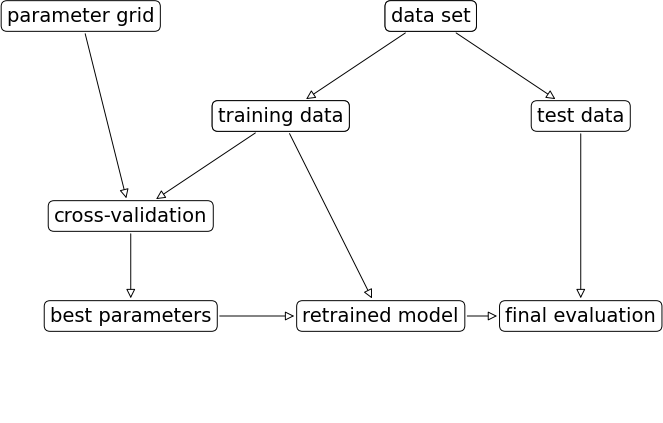

In [2]:
import mglearn
mglearn.plots.plot_grid_search_overview()

## 0. Function definitions

In [3]:
from sklearn.model_selection import cross_validate

def get_classifier_cv_score(model, X, y, scoring='accuracy', cv=7):
    '''Calculate train and validation scores of classifier (model) using cross-validation

        model (sklearn classifier): Classifier to train and evaluate
        X (numpy.array or pandas.DataFrame): Feature matrix
        y (numpy.array or pandas.Series): Target vector
        scoring (str): a scoring string accepted by sklearn.metrics.cross_validate()
        cv (int): number of cross-validation folds see sklearn.metrics.cross_validate()

        returns: mean training score, mean validation score
    '''

    score = cross_validate(estimator=model, X=X, y=y,
                           cv=cv, scoring=scoring, return_train_score=True)
    score_train = score['train_score'].mean()
    score_test = score['test_score'].mean()

    return (score_train, score_test)

In [4]:
def print_grid_search_result(grid_search):
    '''Prints summary of best model from GridSearchCV object.
    
        For the best model of the grid search, print:
        - parameters 
        - cross-validation training score
        - cross-validation validation score 
        
        scores are printed with 3 decimal places.
    
        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object
        
        returns: None
    '''
    
    print("Best parameters   = {}".format(grid_search.best_params_))
    print("CV Training Score = {:.3f}".format(grid_search.cv_results_['mean_train_score'].max()))
    print("CV Test Score     = {:.3f}".format(grid_search.cv_results_['mean_test_score'].max()))
    
    return None

In [5]:
import mglearn

def plot_grid_search_results(grid_search):
    '''For grids with 2 hyperparameters, create a heatmap plot of test scores
        
        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object
        
        uses mglearn.tools.heatmap() for plotting.
    '''
    results = pd.DataFrame(grid_search.cv_results_)

    params = sorted(grid_search.param_grid.keys())
    
    assert len(params) == 2, "We can only plot two parameters."
    
    # second dimension in reshape are rows, needs to be the fast changing parameter
    scores = np.array(results.mean_test_score).reshape(len(grid_search.param_grid[params[0]]),
                                                      len(grid_search.param_grid[params[1]]))

    # plot the mean cross-validation scores
    # x-axis needs to be the fast changing parameter
    mglearn.tools.heatmap(scores, 
                          xlabel=params[1], 
                          xticklabels=grid_search.param_grid[params[1]], 
                          ylabel=params[0], 
                          yticklabels=grid_search.param_grid[params[0]],
                          cmap="viridis", fmt="%0.3f")

In [6]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_actual, y_pred, labels, title=''):
    '''Creates a heatmap plot of the confusion matrix.

        y_actual (pandas.DataSeries or numpy.Array): Ground truth label vector
        y_pred (pandas.DataSeries or numpy.Array): Predicted label vector
        labels (list(str)): Class names used for plotting (ticklabels)
        title (str): Plot title

        uses sklearn.metrics.confusion_matrix
    '''

    cm = confusion_matrix(y_actual, y_pred)
    sns.heatmap(data=cm, xticklabels=labels, yticklabels=labels, cbar=False, square=True, annot=True, fmt='g')
    plt.xlabel('predicted value')
    plt.ylabel('true value')
    plt.title(title)

## 1. Load data
yellowbrick mushroom  
https://www.scikit-yb.org/en/latest/api/datasets/mushroom.html




### 1.1 Prepare the feature matrix and target vector

Using the yellowbrick `load_mushroom()` function, load the mushroom data set into feature matrix `X` and target vector `y`.

Print shape and type of `X`, `y`.

In [7]:
from yellowbrick.datasets import load_mushroom
X, y = load_mushroom()

print("Type of X = {}, Shape of X = {}".format(type(X), X.shape))
print("Type of y = {}, Shape of y = {}".format(type(X), y.shape))

Type of X = <class 'pandas.core.frame.DataFrame'>, Shape of X = (8123, 3)
Type of y = <class 'pandas.core.frame.DataFrame'>, Shape of y = (8123,)


## 2. Inspect the data 

### 2.1 Relationship between features and target classes

To understand the relationship between categorical features and target classes better, it is usefull to produce barplots with bars for each target class. Using seaborn `countplot()`, produce a barplot for each of the three feature columns in `X` using  `y` as hue.

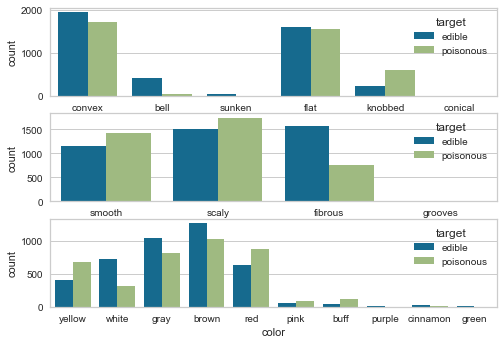

In [8]:
fig = plt.figure(1)
axs = fig.subplots(3, 1)

sns.countplot(data=X, hue=y, x="shape", ax=axs[0]);
sns.countplot(data=X, hue=y, x="surface", ax=axs[1]);
sns.countplot(data=X, hue=y, x="color", ax=axs[2]);

## 3. Preprocessing
In this dataset, all features are discrete and nominal and need to be encoded. You will use a `OneHotEncoder`.

The target vector is discrete and nominal as well. While sklearn is OK using string labels, you will use a `LabelEncoder` to convert strings to integers and keep the encoder to translate between the two representations.

### 3.1 Onehot encoding of features
Use `OneHotEncoder` to convert `X` into one-hot-encoded features stored in a varible `X_enc`. Use `spares=False`. Print shape of `X_enc`.

In [9]:
from sklearn.preprocessing import OneHotEncoder
encoder_onehot = OneHotEncoder(sparse=False)
X_enc = encoder_onehot.fit(X).transform(X)

print(X_enc.shape)

(8123, 20)


### 3.2 Label encode target vector 
Use `LabelEncoder` to encode the target vector `y`, saved in a varibale `y_enc`.

Print the resulting target vector `y_enc` and print the class names available in the `classes_` attribute of the `LabelEncoder` object.

In [10]:
from sklearn.preprocessing import LabelEncoder
encoder_label = LabelEncoder()
y_enc = encoder_label.fit(y).transform(y)

print("Encoded Target =", y_enc)
print("Class Names    =", encoder_label.classes_)

Encoded Target = [0 0 1 ... 0 1 0]
Class Names    = ['edible' 'poisonous']


### *Question 1:* How are class label strings mapped to integers? Show an example for both.
Hint: use `transform()` or `inverse_transform()` method of the `LabelEncoder` object.

In [11]:
encoder_label.transform(encoder_label.classes_)

array([0, 1])

In [12]:
print("0 = {}\n1 = {}".format(encoder_label.inverse_transform([0]), encoder_label.inverse_transform([1])))

0 = ['edible']
1 = ['poisonous']


## 4. Create training and test sets
Using scikit-learn `train_test_split()` with parameters `random_state=37`, `test_size=0.2`, split `X_enc` and `y_enc` into training and test sets.

In [13]:
from sklearn.model_selection import train_test_split

# split the data into training set and validation set
X_train, X_test, y_train, y_test = train_test_split(X_enc, y_enc, random_state=37, test_size=0.2)

## 5. Compare models using cross-validation
Create a list containing a `LogisticRegression()`, 
          `SVC()`,
          `BernoulliNB()`,
        `RandomForestClassifier(random_state=55)`, 
         `GradientBoostingClassifier(random_state=56)` objects.

Iterate this list, then:
- compute the **average precision** using `get_classifier_cv_score()` defined above, 
- rank the models based on validation **average precision** (best first),
- and print the ranked models training and validation scores with **3 decimal places**. 

Use training data and 7-fold cross-validation.

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# model list
model_list = [LogisticRegression(), SVC(), BernoulliNB(), RandomForestClassifier(
    random_state=55), GradientBoostingClassifier(random_state=56)]

result_list = []

# iterate over the models to get the train and test score and store in results list
for m in model_list:
    (score_train, score_test) = get_classifier_cv_score(m, X_train, y_train, scoring='average_precision')
    result_list.append((m.__class__.__name__, score_train, score_test))


# sort the list based on test score
result_list.sort(key = lambda item: item[2], reverse=True)

# print the header
print("+----------------------------+-------------+------------+")
print("| model name                 | train_score | test_score |")
print("+----------------------------+-------------+------------+")

# print the models
for r in result_list:
    print("| {:<26} | {:11.3f} | {:10.3f} |".format(r[0], r[1], r[2]))
print("+----------------------------+-------------+------------+")

+----------------------------+-------------+------------+
| model name                 | train_score | test_score |
+----------------------------+-------------+------------+
| RandomForestClassifier     |       0.806 |      0.792 |
| GradientBoostingClassifier |       0.793 |      0.788 |
| SVC                        |       0.710 |      0.699 |
| BernoulliNB                |       0.669 |      0.667 |
| LogisticRegression         |       0.661 |      0.658 |
+----------------------------+-------------+------------+


## 6. (optional) Hyperparameter tuning using grid search 

The inital cross-validation above showed that both DecisionTree based models might have merit. 

Support vector machine classifier might also perform well if properly tuned.

Next, hyperparameters are tuned using grid search.

### 6.1 Grid search for RandomForestClassifier 

Perform grid search using `GridSearchCV` for the `RandomForestClassifier(random_state=55)`.

Grid search to use 7-fold cross-validation, and `average_precision` as the scoring function. Note that there is a `n_jobs` parameter to run search in parallel. Setting it to the number of CPU cores works well.

Use the following hyperparameters and values:
- `'n_estimators': [300, 500, 700, 1000]`
- `'max_depth': [7, 9, 11, 13]`

Use `print_grid_search_result()` and `plot_grid_search_result()` functions defined above to show the results.

In [15]:
from sklearn.model_selection import GridSearchCV

# create the parameter grid
param_grid_rfc = {
    'n_estimators': [300, 500, 700, 1000],
    'max_depth': [7, 9, 11, 13]
}

# setup the grid search
grid_rfc = GridSearchCV(RandomForestClassifier(random_state=55), param_grid_rfc,
                        n_jobs=4, cv=7, scoring='average_precision', return_train_score=True)

In [16]:
# perform the grid search
grid_rfc.fit(X_train, y_train)

GridSearchCV(cv=7, estimator=RandomForestClassifier(random_state=55), n_jobs=4,
             param_grid={'max_depth': [7, 9, 11, 13],
                         'n_estimators': [300, 500, 700, 1000]},
             return_train_score=True, scoring='average_precision')

In [17]:
# print the grid search results
print_grid_search_result(grid_rfc)

Best parameters   = {'max_depth': 11, 'n_estimators': 700}
CV Training Score = 0.806
CV Test Score     = 0.794


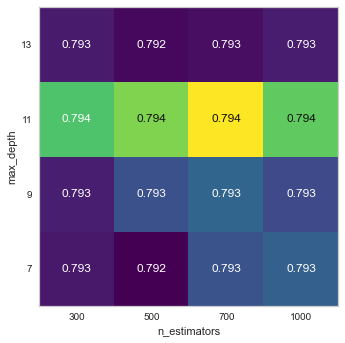

In [18]:
# plot validation metrics for all hyperparameter combinations
plot_grid_search_results(grid_rfc);

### 6.2 Gradient boosting classifier 
Perform grid search using `GridSearchCV` for the `GradientBoostingClassifier(max_depth=5, random_state=56)`.

Grid search to use 7-fold cross-validation, and `average_precision` as the scoring function. Note that there is a `n_jobs` parameter to run search in parallel. Setting it to the number of CPU cores works well.

Use the following hyperparameters and values:
- `'n_estimators': [50, 100, 200]`,
- `'learning_rate': [0.001, 0.01, 0.1, 1.0]`

Use `print_grid_search_result()` and `plot_grid_search_result()` functions defined above to show the results.

In [19]:
# create the parameter grid
param_grid_gbt = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.001, 0.01, 0.1, 1.0]
}

# setup the grid search
grid_gbt = GridSearchCV(GradientBoostingClassifier(max_depth=5, random_state=56), param_grid_gbt,
                        n_jobs=4, cv=7, scoring='average_precision', return_train_score=True)

In [20]:
# perform the grid search
grid_gbt.fit(X_train, y_train)

GridSearchCV(cv=7,
             estimator=GradientBoostingClassifier(max_depth=5, random_state=56),
             n_jobs=4,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 1.0],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True, scoring='average_precision')

In [21]:
# print the grid search results
print_grid_search_result(grid_gbt)

Best parameters   = {'learning_rate': 0.1, 'n_estimators': 100}
CV Training Score = 0.807
CV Test Score     = 0.795


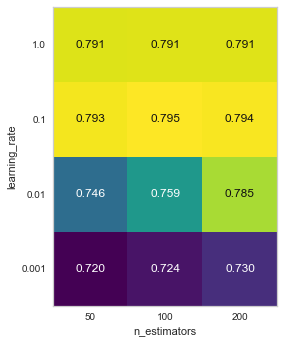

In [22]:
# plot validation metrics for all hyperparameter combinations
plot_grid_search_results(grid_gbt);

### 6.3 SVC grid search
Perform grid search using `GridSearchCV` for the `SVC()`.

Grid search to use 7-fold cross-validation, and `average_precision` as the scoring function. Note that there is a `n_jobs` parameter to run search in parallel. Setting it to the number of CPU cores works well.

Use the following hyperparameters and values:
- `'C': [0.0001, 0.001, 0.01, 0.1]`
- `'gamma': [0.1, 1, 10, 100]`

Use `print_grid_search_result()` and `plot_grid_search_result()` functions defined above to show the results.

In [23]:
# create the parameter grid
param_grid_svc = {
    'C': [0.0001, 0.001, 0.01, 0.1],
    'gamma': [0.1, 1, 10, 100]
}

# setup the grid search
grid_svc = GridSearchCV(SVC(), param_grid_svc,
                        n_jobs=4, cv=7, scoring='average_precision', return_train_score=True)

In [24]:
# perform the grid search
grid_svc.fit(X_train, y_train)

GridSearchCV(cv=7, estimator=SVC(), n_jobs=4,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1],
                         'gamma': [0.1, 1, 10, 100]},
             return_train_score=True, scoring='average_precision')

In [25]:
# print the grid search results
print_grid_search_result(grid_svc)

Best parameters   = {'C': 0.0001, 'gamma': 10}
CV Training Score = 0.779
CV Test Score     = 0.772


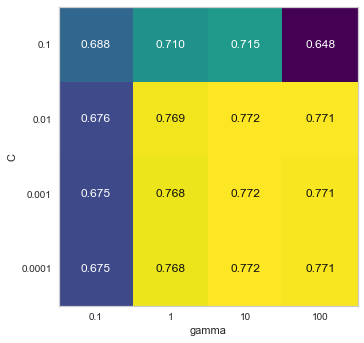

In [26]:
# plot validation metrics for all hyperparameter combinations
plot_grid_search_results(grid_svc);

### *Question 2:* What are the training and validation scores of the three tuned (best) models? Summarize the results here.

*ADD YOUR ANSWER HERE*

## 7. (optional) Best model: Find a better threshold

### 7.1 Precision and recall curve

From the results above, it looks like `GradientBoosingClassifier()` performs well.

Using the training dataset and best `GradientBoosingClassifier()` from the grid search above:
1. Calculate predicted probabilities using `cross_val_predict()` with parameters `cv=7, method='predict_proba'`.
2. Plot the precision-recall curve indicating where the default threshold 0.5 lies (see lecture notebook for an example).

Include a legend and axis labels.


In [27]:
#TODO: Calculate predicted probabilities using cross_val_predict(cv=7, method='predict_proba')


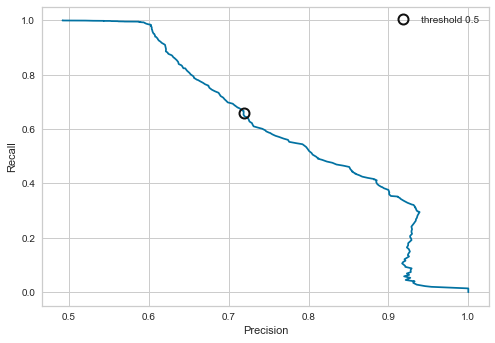

In [28]:
#TODO: Plot precision-recall curve


### 7.2 Find a better threshold
It is important in this application to achieve high recall. Determine the probability threshold to achieve recall higher than 0.999. Store this threshold in a variable and print it.

In [29]:
#TODO: Find and print threshold for recall>0.999


0.021030500536382234

## 8. Retrain best model
Retrain the best `GradientBoostingClassifier()` from the grid search above on the training dataset.

In [30]:
#TDOD: Retrain gradient boosting classifier


GradientBoostingClassifier(max_depth=5, random_state=56)
{'learning_rate': 0.1, 'n_estimators': 100}


## 9. Evaluate on test data

Using the retrained model and the test dataset:
- print the classification report
- plot the confusion matrix using plot_confusion_matrix()

Make sure the plot has class labels and a title.

Repeat these steps for the default threshold and the optimal threshold determined in step 7.

### 9.1 Evaluation with default threshold

In [31]:
#TODO: print classification report using default threshold


              precision    recall  f1-score   support

           0       0.69      0.76      0.72       843
           1       0.71      0.63      0.67       782

    accuracy                           0.70      1625
   macro avg       0.70      0.69      0.69      1625
weighted avg       0.70      0.70      0.70      1625



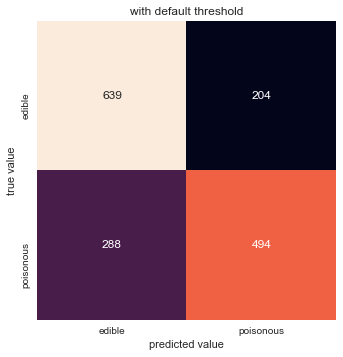

In [32]:
#TODO: call plot_confusion_matrix(), use LabelEncoder classes_ to get labels


### 9.2 (optional) Evaluation with new threshold form Step 7.

In [33]:
#TODO: print classification report using default threshold


              precision    recall  f1-score   support

           0       1.00      0.10      0.19       843
           1       0.51      1.00      0.67       782

    accuracy                           0.54      1625
   macro avg       0.75      0.55      0.43      1625
weighted avg       0.76      0.54      0.42      1625



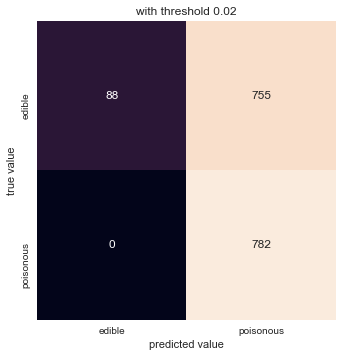

In [34]:
#TODO: call plot_confusion_matrix(), use LabelEncoder classes_ to get labels


### *Question 3:* What are the precision, recall and accuracy on the test set using the default and optimal thresholds of the best gradient boosting model?

*ADD YOUR ANSWER HERE*

### *Question 4:* How many false negatives does the model produce on the test set with the default and optimal thresholds of the best gradient boosting model?

*ADD YOUR ANSWER HERE*

## 10. Conclusion

In conclusion, comment on the following items:
1. In the classification of edible vs poisonous mushrooms, why is high recall desired?
1. In the classification of edible vs poisonous mushrooms, what do false positive and false negative predictions imply and what are the consequences of making these mistakes?
1. Is the final model satisfactory, i.e. a useful model for the task, or is more work needed? Explain.

*ADD YOUR ANSWER HERE*



## 11. Reflection
Include a sentence or two about:
- what you liked or disliked,
- found interesting, confusing, challangeing, motivating while working on this assignment.

*ADD YOUR THOUGHTS HERE*

